In [3]:
# 02_baseline_single_modality.ipynb
''' Train baseline classifiers per modality on the processed dataset — RandomForest & XGBoost. 
**Notebook goals**
- Load processed features and target saved by `01_preprocessing.ipynb`.
- Define modality groups by column name heuristics (EEG, EYE, GSR, FACE, OTHER).
- For each modality:
  - Build pipelines (imputer/scaler + classifier).
  - Run stratified cross-validation (accuracy & F1 macro).
  - Fit on training set, evaluate on hold-out test set.
  - Save model and metrics.
- Save `reports/baseline_metrics.csv` and models under `models/`.'''


' Train baseline classifiers per modality on the processed dataset — RandomForest & XGBoost. \n**Notebook goals**\n- Load processed features and target saved by `01_preprocessing.ipynb`.\n- Define modality groups by column name heuristics (EEG, EYE, GSR, FACE, OTHER).\n- For each modality:\n  - Build pipelines (imputer/scaler + classifier).\n  - Run stratified cross-validation (accuracy & F1 macro).\n  - Fit on training set, evaluate on hold-out test set.\n  - Save model and metrics.\n- Save `reports/baseline_metrics.csv` and models under `models/`.'

In [4]:
# Standard imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Data
import numpy as np
import pandas as pd

# Modeling & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import json
import time

# Optional: XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# Repro
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
REPORTS_DIR = ROOT / "reports"

for d in (DATA_DIR, MODELS_DIR, REPORTS_DIR):
    d.mkdir(parents=True, exist_ok=True)


In [5]:
def load_data():
    """
    Load train/test splits if present, otherwise load processed_features and split.
    Returns: X_train, X_test, y_train, y_test (all as DataFrames/Series)
    """
    # Preferred: splits produced earlier
    x_train_path = DATA_DIR / "X_train.csv"
    x_test_path = DATA_DIR / "X_test.csv"
    y_train_path = DATA_DIR / "y_train.csv"
    y_test_path = DATA_DIR / "y_test.csv"
    processed_path = DATA_DIR / "processed_features.csv"
    processed_no_target_path = DATA_DIR / "processed_features_no_target.csv"

    if x_train_path.exists() and x_test_path.exists() and y_train_path.exists() and y_test_path.exists():
        X_train = pd.read_csv(x_train_path)
        X_test = pd.read_csv(x_test_path)
        y_train = pd.read_csv(y_train_path).squeeze()
        y_test = pd.read_csv(y_test_path).squeeze()
        return X_train, X_test, y_train, y_test

    # fallback: try processed_features.csv that includes target
    if processed_path.exists():
        df = pd.read_csv(processed_path)
        # assume last column is target (common pattern from preprocessing)
        target_col = df.columns[-1]
        X = df.drop(columns=[target_col])
        y = df[target_col]
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED,
            stratify=y if y.nunique() > 1 else None
        )
        return X_train, X_test, y_train, y_test

    # if only features are available (no target) raise
    raise FileNotFoundError("Required data not found. Ensure data/X_train.csv, X_test.csv, y_train.csv, y_test.csv or data/processed_features.csv are present.")

def save_json(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"Saved JSON: {path}")

def save_joblib(obj, path):
    path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(obj, path)
    print(f"Saved joblib: {path}")


In [6]:
X_train, X_test, y_train, y_test = load_data()
print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)
display(X_train.head(2))
display(y_train.value_counts().to_frame("count"))


Shapes -> X_train: (1158, 54) X_test: (290, 54) y_train: (1158,) y_test: (290,)


,StudentID,EEG_Delta_mean,EEG_Delta_var,EEG_Theta_mean,EEG_Theta_var,EEG_Alpha_mean,EEG_Alpha_var,EEG_Beta_mean,EEG_Beta_var,EEG_Gamma_mean,...,TrialID_Item20,TrialID_Item3,TrialID_Item4,TrialID_Item5,TrialID_Item6,TrialID_Item7,TrialID_Item8,TrialID_Item9,TrialID_spl1,TrialID_spl2
0,-0.631579,-0.041358,0.851699,-0.007236,0.092247,-0.246479,0.362322,-0.281165,-0.234256,-0.092357,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.789474,0.138433,-0.046146,0.170586,-0.418611,0.833104,-0.799311,0.773833,-0.484254,0.643622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,count
Label,
1,892
0,266


In [7]:
# Ensure y are single-dimensional Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()

# Encode labels -> ensure numeric labels for classifiers and metrics
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Save label encoder
save_joblib(label_encoder, MODELS_DIR / "label_encoder.joblib")

# Determine if binary classification
n_classes = len(label_encoder.classes_)
print("Classes (n={}):".format(n_classes), label_encoder.classes_)

BINARY = (n_classes == 2)


Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\label_encoder.joblib
Classes (n=2): [0 1]


In [8]:
# Modality heuristics — tune these strings if your dataset uses different column naming
col_lower = [c.lower() for c in X_train.columns]
col_map = dict(zip(X_train.columns, col_lower))

def pick_cols_by_keywords(keywords):
    ks = [k.lower() for k in keywords]
    return [orig for orig, low in col_map.items() if any(k in low for k in ks)]

modalities = {
    "EEG": pick_cols_by_keywords(["eeg", "alpha", "beta", "theta", "delta", "hz"]),
    "EYE": pick_cols_by_keywords(["eye", "pupil", "gaze", "saccade", "blink"]),
    "GSR": pick_cols_by_keywords(["gsr", "skin_conductance", "conductance", "eda"]),
    "FACE": pick_cols_by_keywords(["au", "landmark", "face", "facs", "action_unit", "tiva"]),
}

# "OTHER" contains columns not matched above
matched = set(sum(modalities.values(), []))
other_cols = [c for c in X_train.columns if c not in matched]
modalities["OTHER"] = other_cols

# Print counts
for k, v in modalities.items():
    print(f"{k}: {len(v)} cols")


EEG: 12 cols
EYE: 4 cols
GSR: 4 cols
FACE: 9 cols
OTHER: 25 cols


In [9]:
def build_pipeline(classifier, use_feature_select=False, k_best=200):
    steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
    if use_feature_select:
        steps.append(("select", SelectKBest(score_func=f_classif, k=k_best)))
    steps.append(("clf", classifier))
    return Pipeline(steps)

def evaluate_cv(pipeline, X, y, cv_splits=5):
    scoring = ["accuracy", "f1_macro"]
    if BINARY:
        scoring.append("roc_auc")
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_SEED)
    res = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    # aggregate
    summary = {k: float(np.mean(res[k])) for k in res if k.startswith("test_")}
    return summary

def fit_and_evaluate(pipeline, X_train_sub, y_train_sub, X_test_sub, y_test_sub):
    # Fit
    pipeline.fit(X_train_sub, y_train_sub)
    preds = pipeline.predict(X_test_sub)
    acc = accuracy_score(y_test_sub, preds)
    f1 = f1_score(y_test_sub, preds, average="macro")
    out = {"accuracy_test": float(acc), "f1_macro_test": float(f1)}
    if BINARY:
        proba = pipeline.predict_proba(X_test_sub)[:,1]
        try:
            auc = roc_auc_score(y_test_sub, proba)
            out["roc_auc_test"] = float(auc)
        except Exception:
            out["roc_auc_test"] = None
    # classification report
    report = classification_report(y_test_sub, preds, output_dict=True, zero_division=0)
    return out, report, pipeline


In [10]:
results = []
timestamp = time.strftime("%Y%m%d_%H%M%S")

for modality, cols in modalities.items():
    if len(cols) == 0:
        print(f"Skipping {modality} (no columns matched).")
        continue

    print("\n--- Modality:", modality, "| features:", len(cols))

    Xtr_mod = X_train[cols]
    Xte_mod = X_test[cols]

    # If the modality has only one or two features, skip SelectKBest
    use_fs = Xtr_mod.shape[1] > 50

    # RandomForest baseline
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
    rf_pipe = build_pipeline(rf, use_feature_select=use_fs, k_best=min(200, Xtr_mod.shape[1]))
    cv_summary_rf = evaluate_cv(rf_pipe, Xtr_mod, y_train_enc, cv_splits=5)
    fit_out_rf, report_rf, fitted_rf = fit_and_evaluate(rf_pipe, Xtr_mod, y_train_enc, Xte_mod, y_test_enc)

    # Save RF model
    rf_model_path = MODELS_DIR / f"baseline_{modality}_rf_{timestamp}.joblib"
    save_joblib(fitted_rf, rf_model_path)

    # XGBoost baseline (if available)
    xgb_summary = {}
    fit_out_xgb = {}
    report_xgb = None
    xgb_model_path = None
    if XGBOOST_AVAILABLE:
        xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_SEED, n_jobs=1)
        xgb_pipe = build_pipeline(xgb_clf, use_feature_select=use_fs, k_best=min(200, Xtr_mod.shape[1]))
        xgb_summary = evaluate_cv(xgb_pipe, Xtr_mod, y_train_enc, cv_splits=5)
        fit_out_xgb, report_xgb, fitted_xgb = fit_and_evaluate(xgb_pipe, Xtr_mod, y_train_enc, Xte_mod, y_test_enc)
        xgb_model_path = MODELS_DIR / f"baseline_{modality}_xgb_{timestamp}.joblib"
        save_joblib(fitted_xgb, xgb_model_path)
    else:
        print("XGBoost not available in environment — skipping XGB baseline.")

    # Collect results
    res_entry = {
        "modality": modality,
        "n_features": len(cols),
        "rf_cv_accuracy": cv_summary_rf.get("test_accuracy"),
        "rf_cv_f1_macro": cv_summary_rf.get("test_f1_macro"),
        "rf_test_accuracy": fit_out_rf.get("accuracy_test"),
        "rf_test_f1_macro": fit_out_rf.get("f1_macro_test"),
        "rf_model_path": str(rf_model_path),
        "xgb_cv_accuracy": xgb_summary.get("test_accuracy") if xgb_summary else None,
        "xgb_cv_f1_macro": xgb_summary.get("test_f1_macro") if xgb_summary else None,
        "xgb_test_accuracy": fit_out_xgb.get("accuracy_test") if fit_out_xgb else None,
        "xgb_test_f1_macro": fit_out_xgb.get("f1_macro_test") if fit_out_xgb else None,
        "xgb_model_path": str(xgb_model_path) if xgb_model_path else None,
        "rf_classification_report": report_rf,
        "xgb_classification_report": report_xgb
    }
    results.append(res_entry)

# Save aggregated results
metrics_df = pd.DataFrame([{
    "modality": r["modality"],
    "n_features": r["n_features"],
    "rf_cv_accuracy": r["rf_cv_accuracy"],
    "rf_cv_f1_macro": r["rf_cv_f1_macro"],
    "rf_test_accuracy": r["rf_test_accuracy"],
    "rf_test_f1_macro": r["rf_test_f1_macro"],
    "rf_model_path": r["rf_model_path"],
    "xgb_cv_accuracy": r["xgb_cv_accuracy"],
    "xgb_cv_f1_macro": r["xgb_cv_f1_macro"],
    "xgb_test_accuracy": r["xgb_test_accuracy"],
    "xgb_test_f1_macro": r["xgb_test_f1_macro"],
    "xgb_model_path": r["xgb_model_path"]
} for r in results])

metrics_csv_path = REPORTS_DIR / f"baseline_metrics_{timestamp}.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
print("\nSaved metrics to:", metrics_csv_path)

# Save full JSON with classification reports
save_json(results, REPORTS_DIR / f"baseline_results_{timestamp}.json")



--- Modality: EEG | features: 12
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_EEG_rf_20251017_224420.joblib
XGBoost not available in environment — skipping XGB baseline.

--- Modality: EYE | features: 4
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_EYE_rf_20251017_224420.joblib
XGBoost not available in environment — skipping XGB baseline.

--- Modality: GSR | features: 4
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_GSR_rf_20251017_224420.joblib
XGBoost not available in environment — skipping XGB baseline.

--- Modality: FACE | features: 9
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_FACE_rf_20251017_224420.joblib
XGBoost not available in environment — skipping XGB baseline.

--- Modality: OTHER | features: 25
Saved joblib: C:\Users\alfiy\ByteBuzz\Notebooks\models\baseline_OTHER_rf_20251017_224420.joblib
XGBoost not available in environment — skipping XGB baseline.

Saved metrics to: C:\Users\alfiy\ByteBuzz\Note

,modality,n_features,rf_cv_accuracy,rf_cv_f1_macro,rf_test_accuracy,rf_test_f1_macro,rf_model_path,xgb_cv_accuracy,xgb_cv_f1_macro,xgb_test_accuracy,xgb_test_f1_macro,xgb_model_path
0,EEG,12,0.760796,0.441918,0.762069,0.432485,C:\Users\alfiy\ByteBuzz\Notebooks\models\basel...,None,None,None,None,None
1,EYE,4,0.730594,0.496356,0.731034,0.477550,C:\Users\alfiy\ByteBuzz\Notebooks\models\basel...,None,None,None,None,None
2,GSR,4,0.758229,0.539165,0.748276,0.506423,C:\Users\alfiy\ByteBuzz\Notebooks\models\basel...,None,None,None,None,None
3,FACE,9,0.746966,0.483054,0.744828,0.484927,C:\Users\alfiy\ByteBuzz\Notebooks\models\basel...,None,None,None,None,None
4,OTHER,25,0.743499,0.593352,0.758621,0.612714,C:\Users\alfiy\ByteBuzz\Notebooks\models\basel...,None,None,None,None,None


<Figure size 800x400 with 0 Axes>

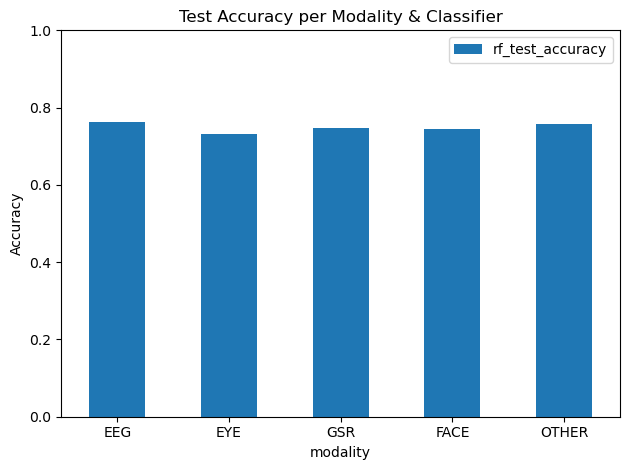

In [11]:
#Summary table & visualization
display(metrics_df)

# quick bar plot of test accuracies
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df_plot = metrics_df.set_index("modality")[[c for c in metrics_df.columns if "test_accuracy" in c]]
df_plot.plot.bar(rot=0)
plt.title("Test Accuracy per Modality & Classifier")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.tight_layout()
plt.show()
